<a href="https://colab.research.google.com/github/duckwarrior103/Transformers/blob/main/transformer-sha/BabyTransformerBlock_embedding_Kyan_Sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing a simple transformer block with embedding and positional encoding


The transformer is defined as follows:

$$
\begin{aligned}
\hat{\mathbf{Y}} &= \text{Transformer}(\mathbf{X}) \\
&= \mathbf{X}
   + \Big[ \big(
       \text{softmax}\!\big(
           \frac{\mathbf{X}\mathbf{W}_q (\mathbf{X}\mathbf{W}_k)^{\top}}{\sqrt{n}}
       \big) \mathbf{X} \mathbf{W}_v \big) \mathbf{W}_1 + \mathbf{B}_1 \Big] \\
&\quad + \text{ReLU}\Bigg[
       \Big(\mathbf{X} +  \big(
           \text{softmax}\!\big(
               \frac{\mathbf{X}\mathbf{W}_q (\mathbf{X}\mathbf{W}_k)^{\top}}{\sqrt{n}}
           \big) \mathbf{X}\mathbf{W}_v \big) \mathbf{W}_1 + \mathbf{B}_1 \Big)
       \mathbf{W}_2 + \mathbf{B}_2 \Bigg] \mathbf{W}_3 + \mathbf{B}_3
\end{aligned}
$$

$$
\hat{\mathbf{Y}} \in \mathbb{R}^{m \times n}, \quad
\mathbf{X} \in \mathbb{R}^{m \times n}, \quad
\mathbf{W}_q, \mathbf{W}_k \in \mathbb{R}^{n \times d_k}, \quad
\mathbf{W}_v \in \mathbb{R}^{n \times d_v},
$$

$$
\mathbf{W}_1 \in \mathbb{R}^{d_v \times n}, \quad
\mathbf{W}_2 \in \mathbb{R}^{n \times d_\text{ff}}, \quad
\mathbf{W}_3 \in \mathbb{R}^{d_\text{ff} \times n}, \quad
\mathbf{B}_1 \in \mathbb{R}^{m \times n}, \quad
\mathbf{B}_2 \in \mathbb{R}^{m \times d_\text{ff}}, \quad
\mathbf{B}_3 \in \mathbb{R}^{m \times n}.
$$

$$
d_\text{ff},\, d_k,\, d_v,\, m,\, n \in \mathbb{Z}_{>0}.
$$


In [ ]:
!pip install torch

### Import libraries and check if GPU is available


In [2]:
# Don't forget to do your imports!!!
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(torch.cuda.is_available())

True


### Self Attention Layer

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, n, d_k, d_v):
        super().__init__()
        self.n = n
        self.d_k = d_k
        self.W_k = nn.Linear(n, d_k)
        self.W_q = nn.Linear(n, d_k)
        self.W_v = nn.Linear(n, d_v)
        self.softmax = nn.Softmax(dim=-1)
        self.output_linear = nn.Linear(d_v, n)

    def forward(self, X):
        K = self.W_k(X)
        Q = self.W_q(X)
        V = self.W_v(X)
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(self.d_k)
        probs = self.softmax(attention_scores)
        attention_output = torch.bmm(probs, V)
        # Pass the output through the linear layer
        # perform residual connection on input X
        return self.output_linear(attention_output)


### MLP Layer

In [4]:
# Coding the MLP Block with residual connection

class MLP(nn.Module):
    def __init__(self, n, d_ff):
        super().__init__()
        self.n = n
        self.layer1 = nn.Linear(n, d_ff)
        self.layer2 = nn.Linear(d_ff, n)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.layer1(X)
        X = self.relu(X)
        X = self.layer2(X)
        return X

### Positional Encoding

- Write something here about positional encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create positional encoding matrix [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer so it's saved but not trained
        self.register_buffer('pe', pe)  # shape [max_len, d_model]

    def forward(self, x):
        """
        x: [batch, seq_len, d_model]
        """
        seq_len = x.size(1)
        # slice positional encoding to match seq_len
        pe_slice = self.pe[:seq_len, :].unsqueeze(0)  # shape [1, seq_len, d_model]
        x = x + pe_slice  # broadcast across batch
        return x

### Transformer
This puts together self-attention and MLP layers with a residual connection in each layer.

In [6]:
class BabyTransformer(nn.Module):
    def __init__(self, d_model, d_k, d_v, d_ff, vocab_size=51, lr=1e-3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.attention = SelfAttention(d_model, d_k, d_v)
        self.mlp = MLP(d_model, d_ff)
        self.unembed = nn.Linear(d_model, vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.epoch_history, self.loss_history, self.val_loss_history = [], [], []


    def forward(self, X):
        X = self.embed(X)
        X = self.pos_encoding(X)
        X = X + self.attention(X)
        X = X + self.mlp(X)
        logits = self.unembed(X)
        return logits

    def train_model(self, X_train, Y_train, X_val, Y_val, epochs=200, lr=1e-3, verbose=True):
        self.optimizer = optim.Adam(self.parameters(), lr)
        for epoch in range(epochs):
            self.train()
            logits = self.forward(X_train)
            loss = self.criterion(
                logits.view(-1, logits.size(-1)),
                Y_train.view(-1)
            )

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # validation
            with torch.no_grad():
                self.eval()
                val_logits = self.forward(X_val)
                val_loss = self.criterion(
                    val_logits.view(-1, val_logits.size(-1)),
                    Y_val.view(-1)
                )

            self.epoch_history.append(epoch)
            self.loss_history.append(loss.item())
            self.val_loss_history.append(val_loss.item())

            if verbose and epoch % 50 == 0:
                print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        self.plot_loss()

    def plot_loss(self):
        plt.figure(figsize=(8,5))
        plt.plot(self.loss_history, label='Train')
        plt.plot(self.val_loss_history, label='Val')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log)')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True, which='both', linestyle='--')
        plt.show()

### Creating our data for training and validation

In [20]:
# Define dimension of input m x n and batch size
n = 4
batch_size = 100000

X = torch.randint(0, 50, (batch_size, n))  # Generate integer data

Y, _ = torch.sort(X, dim=-1)  # Sort each row of X

print("Original X (first 2 rows):\n", X[:2][0])
print("\nY Hat (first 2 rows):\n", Y[:2][0])
print(Y.shape)

Original X (first 2 rows):
 tensor([32,  2,  5, 28], device='cuda:0')

Y Hat (first 2 rows):
 tensor([ 2,  5, 28, 32], device='cuda:0')
torch.Size([100000, 4])


In [21]:
# Split 50/50 into training and validation
split_ratio = 0.5
total_size = X.shape[0]
split_index = int(total_size * split_ratio)

X_train = X[:split_index]
Y_train = Y[:split_index]

X_val = X[split_index:]
Y_val = Y[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)


Shape of X_train: torch.Size([50000, 4])
Shape of Y_train: torch.Size([50000, 4])
Shape of X_val: torch.Size([50000, 4])
Shape of Y_val: torch.Size([50000, 4])


### Initialise our transformer

In [10]:
transformer = BabyTransformer(d_model=128, d_k=50, d_v=50, d_ff=500, vocab_size=51, lr=0.001)

### Training our transformer

Epoch 000 | Train Loss: 0.3124 | Val Loss: 0.3163
Epoch 050 | Train Loss: 0.1521 | Val Loss: 0.1632
Epoch 100 | Train Loss: 0.0552 | Val Loss: 0.0660
Epoch 150 | Train Loss: 0.0212 | Val Loss: 0.0311
Epoch 200 | Train Loss: 0.0099 | Val Loss: 0.0188
Epoch 250 | Train Loss: 0.0054 | Val Loss: 0.0134
Epoch 300 | Train Loss: 0.0033 | Val Loss: 0.0106
Epoch 350 | Train Loss: 0.0022 | Val Loss: 0.0091
Epoch 400 | Train Loss: 0.0016 | Val Loss: 0.0081
Epoch 450 | Train Loss: 0.0012 | Val Loss: 0.0074
Epoch 500 | Train Loss: 0.0009 | Val Loss: 0.0069
Epoch 550 | Train Loss: 0.0007 | Val Loss: 0.0065
Epoch 600 | Train Loss: 0.0006 | Val Loss: 0.0062
Epoch 650 | Train Loss: 0.0005 | Val Loss: 0.0060
Epoch 700 | Train Loss: 0.0004 | Val Loss: 0.0058
Epoch 750 | Train Loss: 0.0004 | Val Loss: 0.0057
Epoch 800 | Train Loss: 0.0003 | Val Loss: 0.0055
Epoch 850 | Train Loss: 0.0003 | Val Loss: 0.0054
Epoch 900 | Train Loss: 0.0002 | Val Loss: 0.0054
Epoch 950 | Train Loss: 0.0002 | Val Loss: 0.0053


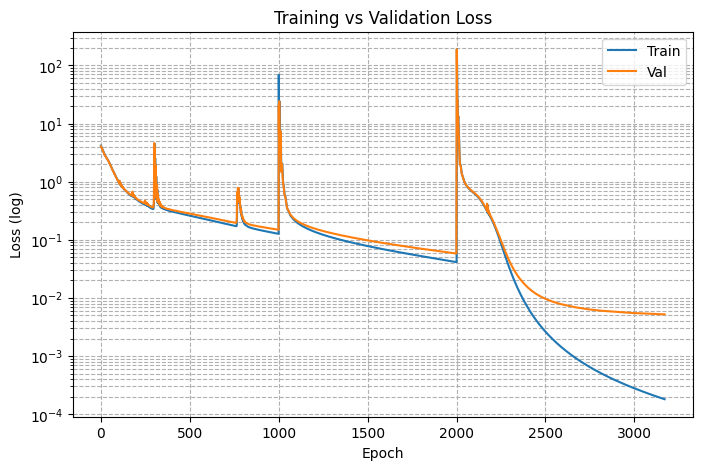

In [32]:
transformer.train_model(X_train, Y_train, X_val, Y_val, epochs=1000, lr=0.0005, verbose=True)

### Inference with one random generated input matrix

In [45]:
with torch.no_grad():
    # Generate a random m x n integer tensor
    test_input = torch.randint(0, 50, (1, n))
    # test_input = X_val[2:3]
    print(test_input)

    expected_output, _ = torch.sort(test_input, dim=-1)
    expected_output = expected_output.view(1, n)

    print(expected_output)

    logits = transformer(test_input)
    preds = torch.argmax(logits, dim=-1)  # (batch, seq_len)
    print(preds)


tensor([[28, 17, 23, 29]], device='cuda:0')
tensor([[17, 23, 28, 29]], device='cuda:0')
tensor([[17, 23, 28, 29]], device='cuda:0')


### Running on test data set

In [46]:
# We need to test our transformer against a broader test data set, and look at its accuracy on unseen data

In [53]:
test_data_size = 500_000

X_test = torch.randint(0, 50, (test_data_size, n))  # Generate integer data

Y_test , _ = torch.sort(X_test, dim=-1)  # Sort each row of X

print("Original X (first 2 rows):\n", X[:2][0])
print("\nY Hat (first 2 rows):\n", Y[:2][0])
print(Y_test.shape)

Original X (first 2 rows):
 tensor([30, 47,  1, 43], device='cuda:0')

Y Hat (first 2 rows):
 tensor([ 1, 30, 43, 47], device='cuda:0')
torch.Size([500000, 4])
